## Deep Learning - Multinomial Classification of Textual Data

The objective of this work is to perform multinomial classification of products based on a text description. Initial data exploration, feature exploration and discussions of performance metrics is given in [this notebook](./initial_data_analysis) This notebook shows an implementation of a neural network text classifier.

In [1]:
%%capture
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
from sklearn.preprocessing import normalize
from pathlib import Path

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow import keras

import datetime

import import_ipynb
from initial_data_analysis import import_format_data

## Neural Network Product Text Category Classifier

For this task, we will use a neural network classifier. Just as in our [Bayes model](./text_classification_bayes.ipynb), the features are derived from a bag of words model of the product descriptions. While our Bayes model used a count vector of product description, this work explores the similar binary vector which measures the presence/absence of a token in a product description. The labels will be the product categories. This section shows the implementation of feedforward neural network classifier model.

### Category Level 1 

First, we look at the classifier performance for level 1 product category classification.

We constructed a 2-layer neural network. The output layer has 14 nodes (number of output labels) with the softmax activation function. The hidden layer consists 140 nodes utilizing the tanh activation function. For the input layer, we restricted the vectorizer's output to a maximum of 30,000 tokens. Training set accuracy dramatically improves with increasing number of possible tokens, but to explore a larger input vector seems to require a better computation platform (e.g. AWS). Dev set and training set accuracy also improves but at a smaller rate. In essence, increasing the input layer's size greatly decreases unavoidable bias (underfitting) in the system, improves overall accuracy, but does notably increase variance (overfitting) as there is now a greater delta in performance between the training set accuracy and dev/test set accuracy. The model's optimizer uses the Adam optimizer to minimize the cross entropy loss function.

For the final metrics of the model before model tuning is as follows: training accuracy was 97.4%, dev set accuracy was 90.6% and test set accuracy was 88.4%.


In [2]:
class TextClassifierNN:
    
    train_data_url = 'https://github.com/up-lab/rakuten-data-challenge/raw/master/rdc-catalog-train.tsv'
    test_data_url = 'https://github.com/up-lab/rakuten-data-challenge/raw/master/rdc-catalog-test.tsv'
    
    random_state = 17
    num_classes = None
    max_features = 30000
    
    train_ds = None
    dev_ds = None
    test_ds = None
    model = None
    
    label_encoder = None
    
    test_data = None
    train_data = None
    
    def __init__(self, label_field='cat_1', text_feature_field='description', hparams={'HP_DROPOUT': 0}, model_path=Path()):
        
        #preprocess input text data to vectorized count features
        self.train_data = import_format_data(self.train_data_url)
        self.test_data = import_format_data(self.test_data_url)

        self.train_ds, self.dev_ds, self.test_ds = self.vectorize_all_text(self.train_data, self.test_data, label_field, text_feature_field)

        #define the model params
        self.hparams = hparams
        
        
        if model_path == Path():
            self.model = self.construct_train_model(self.train_ds, self.dev_ds, hparams)
        else:
            self.model = keras.models.load_model(model_path)
            
        
    def vectorize_all_text(self, train_df, test_df, label_field, text_feature_field):
        #encoder to convert categories to ints
        self.num_classes = len(train_df[label_field].unique())
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(train_df[label_field])
        train_df['label_encoded'] = self.label_encoder.transform(train_df[label_field])
        test_df['label_encoded'] = self.label_encoder.transform(test_df[label_field])
        
        #shuffle and split the training set into a training and dev set
        train, dev = train_test_split(train_df, test_size=0.2, random_state=self.random_state)

        #load them into a tf.data.Dataset object to leverage helper extra functionality
        batch_size = 32
        train_dataset = tf.data.Dataset.from_tensor_slices((train[text_feature_field].values, train['label_encoded'].values))
        train_dataset = train_dataset.batch(batch_size)
        dev_dataset = tf.data.Dataset.from_tensor_slices((dev[text_feature_field].values, dev['label_encoded'].values))
        dev_dataset = dev_dataset.batch(batch_size)
        test_dataset = tf.data.Dataset.from_tensor_slices((test_df[text_feature_field].values, test_df['label_encoded'].values))
        test_dataset = test_dataset.batch(batch_size)
        
        #convert ints to one hot encoding
        #create the vecotrizer
        
        vectorize_layer = TextVectorization(output_mode='binary', max_tokens = self.max_features)

        # Make a text-only dataset (without labels), then call adapt
        train_text = train_dataset.map(lambda x, y: x)
        vectorize_layer.adapt(train_text)
        
        def vectorize_text(text, label):
            text = tf.expand_dims(text, -1)
            return vectorize_layer(text), label


        train_ds = train_dataset.map(vectorize_text)
        dev_ds = dev_dataset.map(vectorize_text)
        test_ds = test_dataset.map(vectorize_text)
        
        return train_ds, dev_ds, test_ds
    
    
    def construct_train_model(self, train_ds, dev_ds, hparams):
        
        model = tf.keras.Sequential([      
            layers.Dense(self.num_classes*10, input_shape=(self.max_features ,), activation='tanh'),
            layers.Dropout(hparams['HP_DROPOUT']),
            layers.Dense(self.num_classes, activation='softmax')])
  
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )
    
        #train model
        epochs = 10
        history = model.fit(
            train_ds,
            validation_data=dev_ds,
            epochs=epochs)
        
        return model                                     
        
    def evaluate_model(self, test_ds=None):
        if test_ds == None:
            test_ds = self.test_ds
        loss, accuracy = self.model.evaluate(test_ds)
        print('Accuracy: ', accuracy)
        return accuracy
        
        
    def save_model(self, filename = None):
        if filename is None:
            filename = 'model_' + datetime.now().strftime("%Y%m%d_%H%M") + '.h5'
        self.model.save(filename)
        
    def display_conf_mat(self):
        """
        Displays confusion matrix for the classifier and test set.

        """

        predictions = self.model.predict(self.test_ds)
        num_labels = self.model.get_layer(index=-1).output_shape[-1]

        cf_matrix = np.zeros((num_labels, num_labels))

        for i, prediction in enumerate(predictions):
            label_actual_idx = self.test_data['label_encoded'][i]
            predict_label_idx = np.argmax(prediction)
            cf_matrix[label_actual_idx, predict_label_idx] += 1

        cf_matrix_norm = normalize(cf_matrix, axis=1, norm='l1')

        sns.heatmap(cf_matrix_norm, xticklabels=self.label_encoder.classes_, yticklabels=self.label_encoder.classes_, cmap="YlGnBu")
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        
        

In [3]:
clf_level1 = TextClassifierNN()

Epoch 1/10
20000/20000 [==============================] - 182s 9ms/step - loss: 0.3693 - sparse_categorical_accuracy: 0.8934 - val_loss: 0.3117 - val_sparse_categorical_accuracy: 0.9080
Epoch 2/10
20000/20000 [==============================] - 181s 9ms/step - loss: 0.2655 - sparse_categorical_accuracy: 0.9204 - val_loss: 0.3021 - val_sparse_categorical_accuracy: 0.9121
Epoch 3/10
20000/20000 [==============================] - 188s 9ms/step - loss: 0.2285 - sparse_categorical_accuracy: 0.9314 - val_loss: 0.3064 - val_sparse_categorical_accuracy: 0.9128
Epoch 4/10
20000/20000 [==============================] - 187s 9ms/step - loss: 0.1965 - sparse_categorical_accuracy: 0.9409 - val_loss: 0.3193 - val_sparse_categorical_accuracy: 0.9118
Epoch 5/10
20000/20000 [==============================] - 184s 9ms/step - loss: 0.1698 - sparse_categorical_accuracy: 0.9494 - val_loss: 0.3357 - val_sparse_categorical_accuracy: 0.9103
Epoch 6/10
20000/20000 [==============================] - 192s 10ms/st

In [4]:
clf_level1.evaluate_model()


6250/6250 [==============================] - 19s 3ms/step - loss: 0.6594 - sparse_categorical_accuracy: 0.8834
Accuracy:  0.8834249973297119


0.8834249973297119

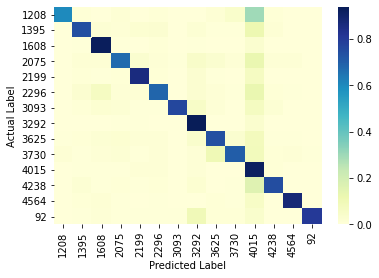

In [5]:
clf_level1.display_conf_mat()

#### Tuning

Because of the large drop in performance between training accuracy (97.4%) and dev(90.6%)/test(88.4%) set accuracy in the original model, it's clear the model is overfitted. Thus, we experimented here with regularization techniques aimed at addressing that. Dropout regularization was added between the hidden layer and the output layer. The figure below shows the dev/test accuracy for different dropout rates and concludes that the optimal dropout rate is 0.5. For the tuned model, our final performance metrics are as follows:
* Training Accuracy: 93.8%
* Dev Accuracy: 91.4%
* Test Accuracy: 89.4%

That's a 1.0% increase in test set accuracy from the original deep learning model and 0.6% improvement over the tuned [Bayes model](./text_classification_bayes.ipynb)!

In [7]:
#run all possible params
session_num = 0
dev_accuracy_all = []
test_accuracy_all = []
drop_out_rates = [0.1, 0.3, 0.5, 0.7]
for dropout_rate in drop_out_rates:
    hparams = {
        'HP_DROPOUT': dropout_rate
    }
    run_name = "run-%d" % session_num
    print('--- Starting trial: %s' % run_name)
    print({k: hparams[k] for k in hparams.keys()})
    
    #train this model
    this_model = TextClassifierNN(hparams = hparams)
    
    #measure dev accuracy
    dev_accuracy = this_model.evaluate_model(this_model.dev_ds)
    dev_accuracy_all.append(dev_accuracy)
    
    #measure test accuracy
    test_accuracy = this_model.evaluate_model()
    test_accuracy_all.append(test_accuracy)
    
    #save model so we can reload the optimal choice later
#     filename = ''
#     for k in hparams.keys():
#         filename = filename + k+'{:f}'.format(hparams[k])
    models_folder = Path("./models_folder/")
    filename = 'session_num' + str(session_num) + '.h5'
    saved_model_filepath = models_folder / filename
    this_model.save_model(saved_model_filepath)
    
    session_num += 1
        


--- Starting trial: run-0
{'HP_DROPOUT': 0.1}
Epoch 1/10
20000/20000 [==============================] - 177s 9ms/step - loss: 0.3727 - sparse_categorical_accuracy: 0.8928 - val_loss: 0.3134 - val_sparse_categorical_accuracy: 0.9074
Epoch 2/10
20000/20000 [==============================] - 171s 9ms/step - loss: 0.2712 - sparse_categorical_accuracy: 0.9192 - val_loss: 0.3049 - val_sparse_categorical_accuracy: 0.9110
Epoch 3/10
20000/20000 [==============================] - 174s 9ms/step - loss: 0.2388 - sparse_categorical_accuracy: 0.9285 - val_loss: 0.3063 - val_sparse_categorical_accuracy: 0.9125
Epoch 4/10
20000/20000 [==============================] - 173s 9ms/step - loss: 0.2128 - sparse_categorical_accuracy: 0.9361 - val_loss: 0.3149 - val_sparse_categorical_accuracy: 0.9118
Epoch 5/10
20000/20000 [==============================] - 173s 9ms/step - loss: 0.1911 - sparse_categorical_accuracy: 0.9427 - val_loss: 0.3250 - val_sparse_categorical_accuracy: 0.9109
Epoch 6/10
20000/20000 [

20000/20000 [==============================] - 175s 9ms/step - loss: 0.2874 - sparse_categorical_accuracy: 0.9190 - val_loss: 0.3125 - val_sparse_categorical_accuracy: 0.9118
Epoch 10/10
5000/5000 [==============================] - 16s 3ms/step - loss: 0.3112 - sparse_categorical_accuracy: 0.9128
Accuracy:  0.9128062725067139
6250/6250 [==============================] - 20s 3ms/step - loss: 0.4325 - sparse_categorical_accuracy: 0.8935
Accuracy:  0.8935350179672241


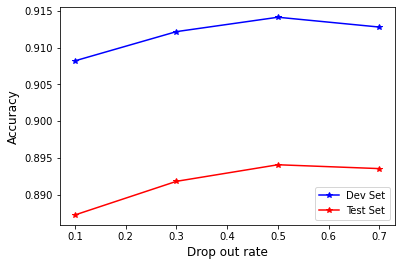

In [8]:
#plot dev and test accuracy for the dropout sweep

plt.plot(drop_out_rates, dev_accuracy_all, '-*b')
plt.plot(drop_out_rates, test_accuracy_all, '-*r')
plt.xlabel('Drop out rate', fontsize='large')
plt.ylabel('Accuracy', fontsize='large')
plt.legend(['Dev Set', 'Test Set'])
plt.show()


In [10]:
#find teh best model
opt_idx = np.argmax(dev_accuracy_all)
#load the model
models_folder = Path("./models_folder/")
filename = 'session_num' + str(opt_idx) + '.h5'
model_filepath = models_folder / filename
this_clf = TextClassifierNN(hparams={'HP_DROPOUT': drop_out_rates[opt_idx]}, model_path=model_filepath)

print('Best Performing Model Final Metrics: ')
print('Training Set Accuracy: ', this_clf.evaluate_model(this_clf.train_ds))
print('Dev Set Accuracy: ', this_clf.evaluate_model(this_clf.dev_ds))
print('Test Set Accuracy: ', this_clf.evaluate_model(this_clf.test_ds))

Best Performing Model Final Metrics: 
20000/20000 [==============================] - 62s 3ms/step - loss: 0.2048 - sparse_categorical_accuracy: 0.9379
Accuracy:  0.9379233121871948
Training Set Accuracy:  0.9379233121871948
5000/5000 [==============================] - 15s 3ms/step - loss: 0.3082 - sparse_categorical_accuracy: 0.9141
Accuracy:  0.9141437411308289
Dev Set Accuracy:  0.9141437411308289
6250/6250 [==============================] - 20s 3ms/step - loss: 0.4436 - sparse_categorical_accuracy: 0.8941
Accuracy:  0.8940600156784058
Test Set Accuracy:  0.8940600156784058


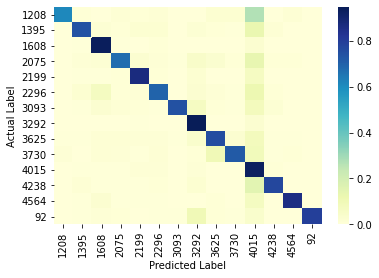

In [11]:
this_clf.display_conf_mat()